In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           precision_recall_curve, roc_curve)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

np.random.seed(42)

***2. Data Loading and Initial Exploration***

In [20]:
# Load the dataset
df = pd.read_csv('/content/malnutrition_prediction_dataset.csv')
print("✅ Dataset loaded successfully!")

# Basic dataset info
print(" DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of samples: {df.shape[0]}")
print("\nColumn names:")
print(df.columns.tolist())

# Display first few rows
print(" FIRST 10 ROWS")
print("=" * 50)
display(df.head(10))

# Data types and missing values
print(" DATA TYPES AND MISSING VALUES")
print("=" * 50)
print(df.info())

# Check for missing values
missing_data = df.isnull().sum()
print(" MISSING VALUES ANALYSIS")
print("=" * 50)
print(missing_data[missing_data > 0])
if missing_data.sum() == 0:
    print(" No missing values found!")

✅ Dataset loaded successfully!
 DATASET OVERVIEW
Dataset shape: (1000, 14)
Number of features: 13
Number of samples: 1000

Column names:
['age_months', 'region', 'rural_urban', 'household_income', 'mother_education', 'family_size', 'breastfeeding', 'vaccination_complete', 'diarrhea_last_week', 'food_insecurity', 'clean_water_access', 'improved_sanitation', 'stunting_risk_score', 'stunting_high_risk']
 FIRST 10 ROWS


,age_months,region,rural_urban,household_income,mother_education,family_size,breastfeeding,vaccination_complete,diarrhea_last_week,food_insecurity,clean_water_access,improved_sanitation,stunting_risk_score,stunting_high_risk
0,41,Western,Rural,59477.216675,Primary,4,1,0,0,0.65,0,1,48.8,1
1,14,Eastern,Rural,54839.245431,Primary,2,1,0,0,0.97,0,0,48.4,1
2,47,Eastern,Rural,52444.383304,No education,3,1,1,1,0.30,0,1,44.4,1
3,37,Western,Urban,42270.540989,No education,5,1,1,0,0.18,1,1,21.2,0
4,20,Eastern,Rural,29818.293143,Primary,6,1,1,0,0.28,0,0,35.1,1
5,6,Kigali,Rural,70619.990450,Secondary,6,1,1,1,0.85,1,0,55.7,1
6,57,Northern,Rural,59157.701540,Primary,7,1,1,0,0.26,0,1,28.6,0
7,22,Eastern,Rural,51740.941365,Primary,5,1,0,0,0.76,0,0,56.5,1
8,24,Eastern,Urban,60028.966630,Secondary,5,0,1,1,0.32,0,0,53.8,1
9,8,Kigali,Rural,32593.900909,Primary,7,0,0,0,0.94,0,1,57.5,1


 DATA TYPES AND MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age_months            1000 non-null   int64  
 1   region                1000 non-null   object 
 2   rural_urban           1000 non-null   object 
 3   household_income      1000 non-null   float64
 4   mother_education      1000 non-null   object 
 5   family_size           1000 non-null   int64  
 6   breastfeeding         1000 non-null   int64  
 7   vaccination_complete  1000 non-null   int64  
 8   diarrhea_last_week    1000 non-null   int64  
 9   food_insecurity       1000 non-null   float64
 10  clean_water_access    1000 non-null   int64  
 11  improved_sanitation   1000 non-null   int64  
 12  stunting_risk_score   1000 non-null   float64
 13  stunting_high_risk    1000 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory 

***3. Data Engineering & Feature Analysis***

In [21]:
# Create new engineered features
print(" FEATURE ENGINEERING")
print("=" * 50)

# Create age categories (critical periods for malnutrition)
def create_age_groups(age_months):
    if age_months < 6:
        return '0-5_months'
    elif age_months < 12:
        return '6-11_months'
    elif age_months < 24:
        return '12-23_months'
    elif age_months < 36:
        return '24-35_months'
    else:
        return '36-59_months'

df['age_group'] = df['age_months'].apply(create_age_groups)

# Create poverty indicator (based on income distribution)
poverty_threshold = df['household_income'].quantile(0.3)  # Bottom 30%
df['poverty_status'] = df['household_income'].apply(
    lambda x: 'Below_poverty' if x < poverty_threshold else 'Above_poverty'
)

# Create composite WASH score
df['wash_score'] = df['clean_water_access'] + df['improved_sanitation']

# Create health vulnerability score
df['health_vulnerability'] = (
    df['diarrhea_last_week'] +
    (1 - df['vaccination_complete']) +
    (1 - df['breastfeeding'])
)

# Create composite risk score
df['composite_risk_score'] = (
    df['food_insecurity'] +
    (1 - df['clean_water_access']) +
    (1 - df['improved_sanitation']) +
    df['health_vulnerability'] / 3
)

print(" New features created:")
new_features = ['age_group', 'poverty_status', 'wash_score', 'health_vulnerability', 'composite_risk_score']
for feature in new_features:
    print(f"  - {feature}")

# Display engineered features
print(" ENGINEERED FEATURES SAMPLE")
print("=" * 50)
engineered_features = df[['age_months', 'age_group', 'household_income', 'poverty_status',
                         'wash_score', 'health_vulnerability', 'composite_risk_score']].head()
display(engineered_features)

 FEATURE ENGINEERING
 New features created:
  - age_group
  - poverty_status
  - wash_score
  - health_vulnerability
  - composite_risk_score
 ENGINEERED FEATURES SAMPLE


,age_months,age_group,household_income,poverty_status,wash_score,health_vulnerability,composite_risk_score
0,41,36-59_months,59477.216675,Above_poverty,1,1,1.983333
1,14,12-23_months,54839.245431,Above_poverty,0,1,3.303333
2,47,36-59_months,52444.383304,Above_poverty,1,1,1.633333
3,37,36-59_months,42270.540989,Above_poverty,2,0,0.180000
4,20,12-23_months,29818.293143,Below_poverty,0,0,2.280000


***4. Comprehensive Data Visualization***

 DATA VISUALIZATION SECTION


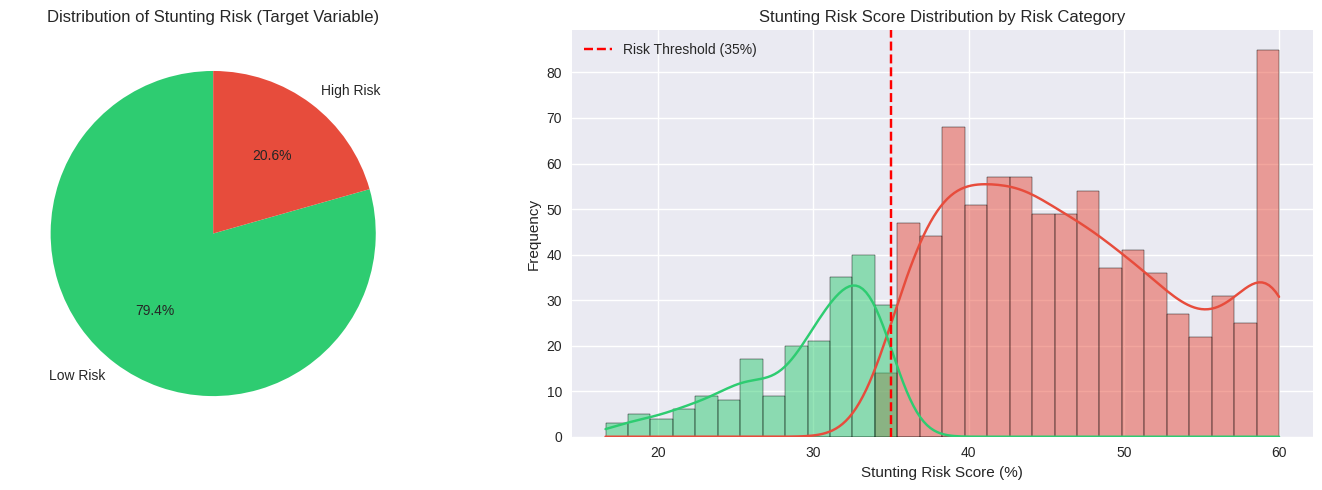

 STRONG CORRELATION ANALYSIS
Correlations with Stunting High Risk:
stunting_high_risk      1.000000
stunting_risk_score     0.704643
composite_risk_score    0.417392
health_vulnerability    0.276247
food_insecurity         0.196503
age_months              0.017147
family_size             0.007859
household_income       -0.001329
clean_water_access     -0.178460
improved_sanitation    -0.230096
wash_score             -0.286524
Name: stunting_high_risk, dtype: float64


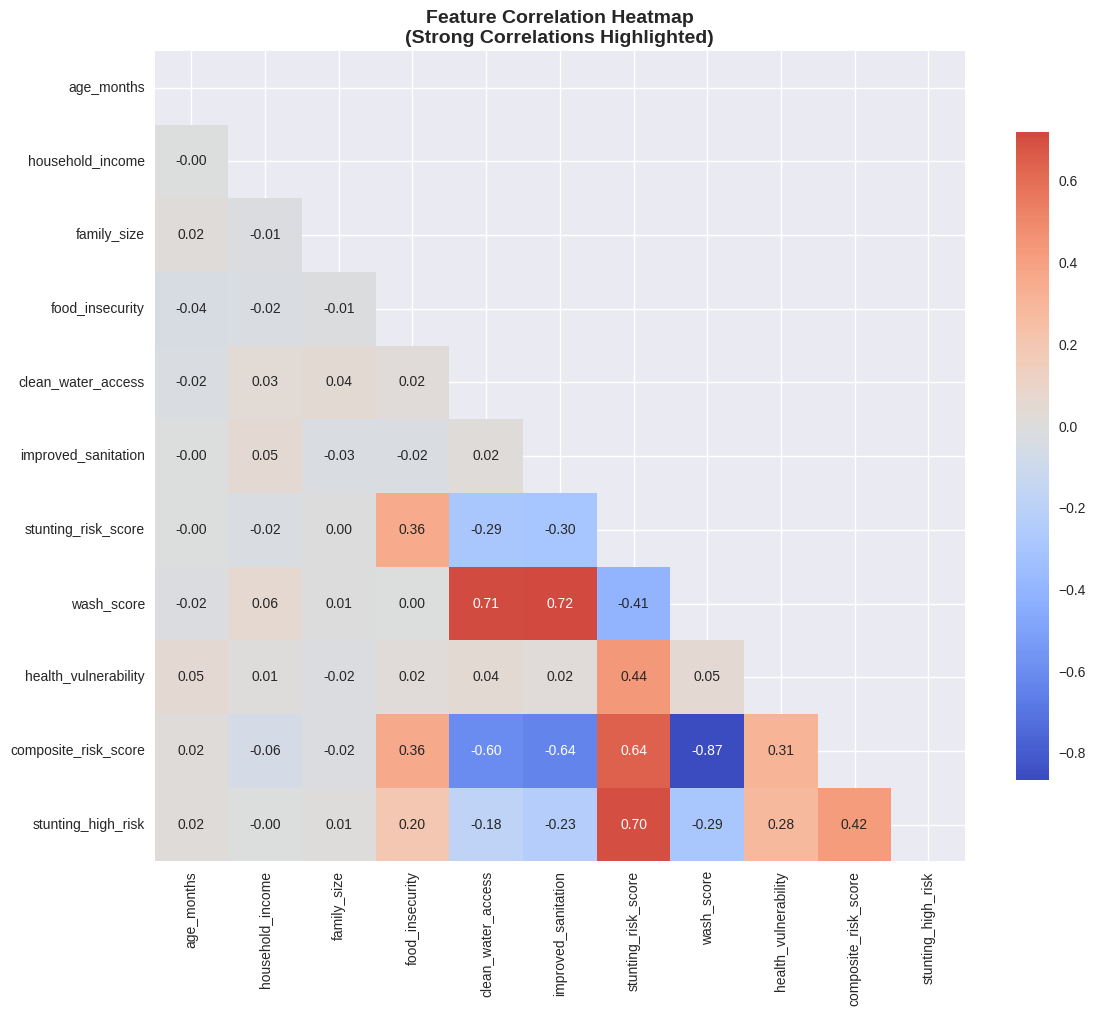

 STRONG CORRELATION PAIRS (|r| > 0.3)
Top Strongly Correlated Feature Pairs:
  wash_score ↔ composite_risk_score: -0.867
  improved_sanitation ↔ wash_score: 0.720
  clean_water_access ↔ wash_score: 0.708
  stunting_risk_score ↔ stunting_high_risk: 0.705
  stunting_risk_score ↔ composite_risk_score: 0.640
  improved_sanitation ↔ composite_risk_score: -0.635
  clean_water_access ↔ composite_risk_score: -0.602
  stunting_risk_score ↔ health_vulnerability: 0.436
  composite_risk_score ↔ stunting_high_risk: 0.417
  stunting_risk_score ↔ wash_score: -0.413


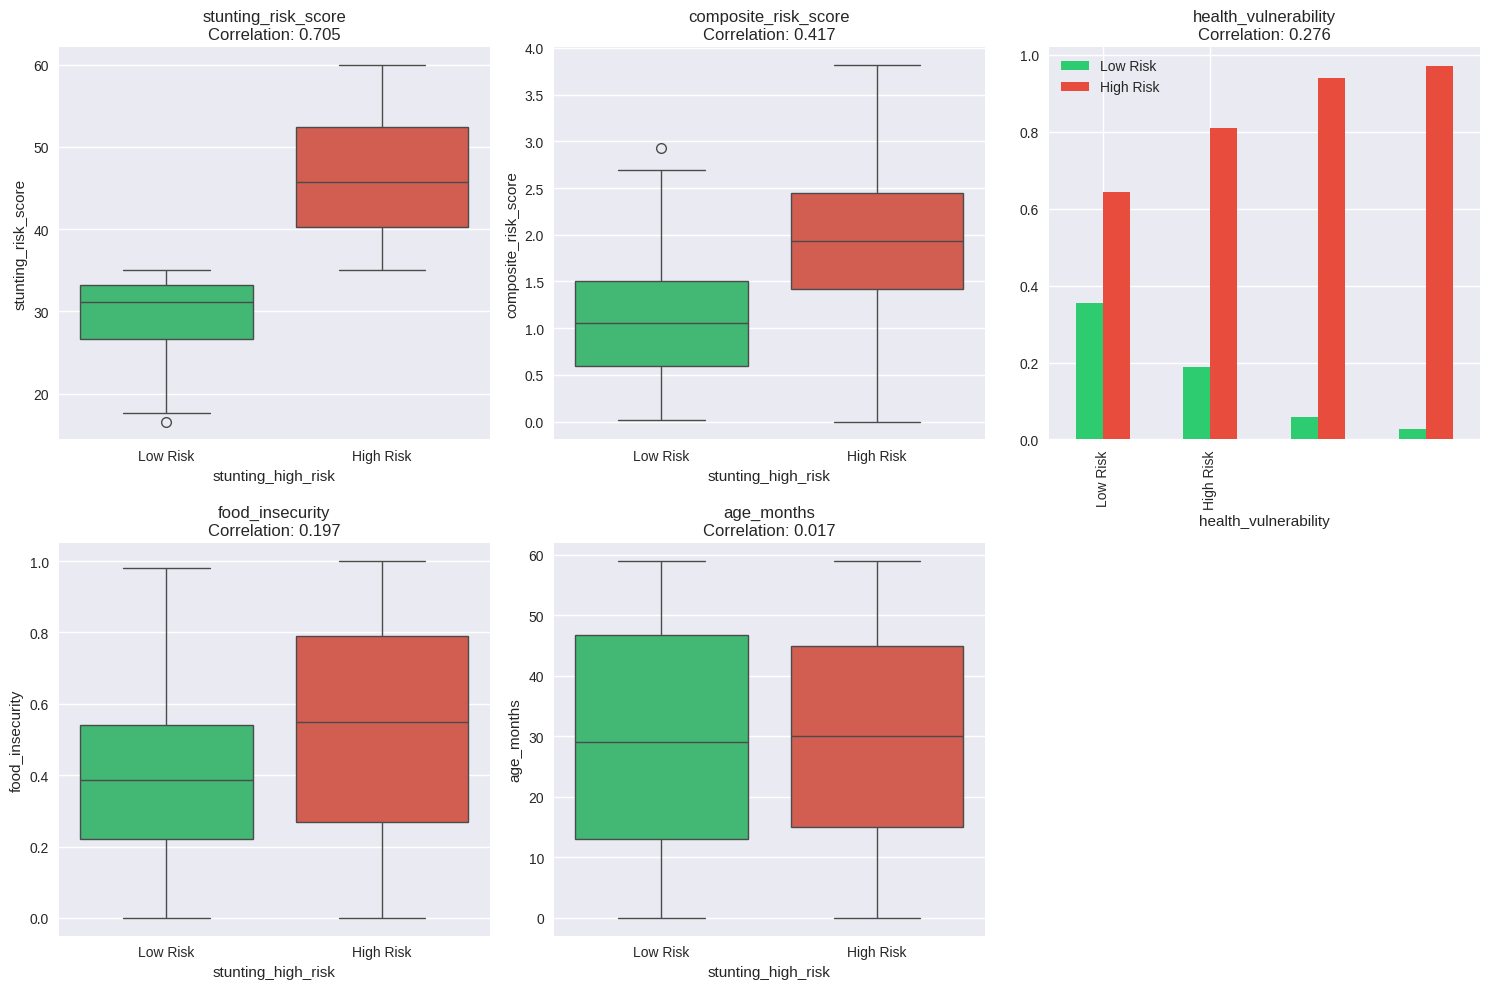

 KEY PREDICTORS BY RISK CATEGORY


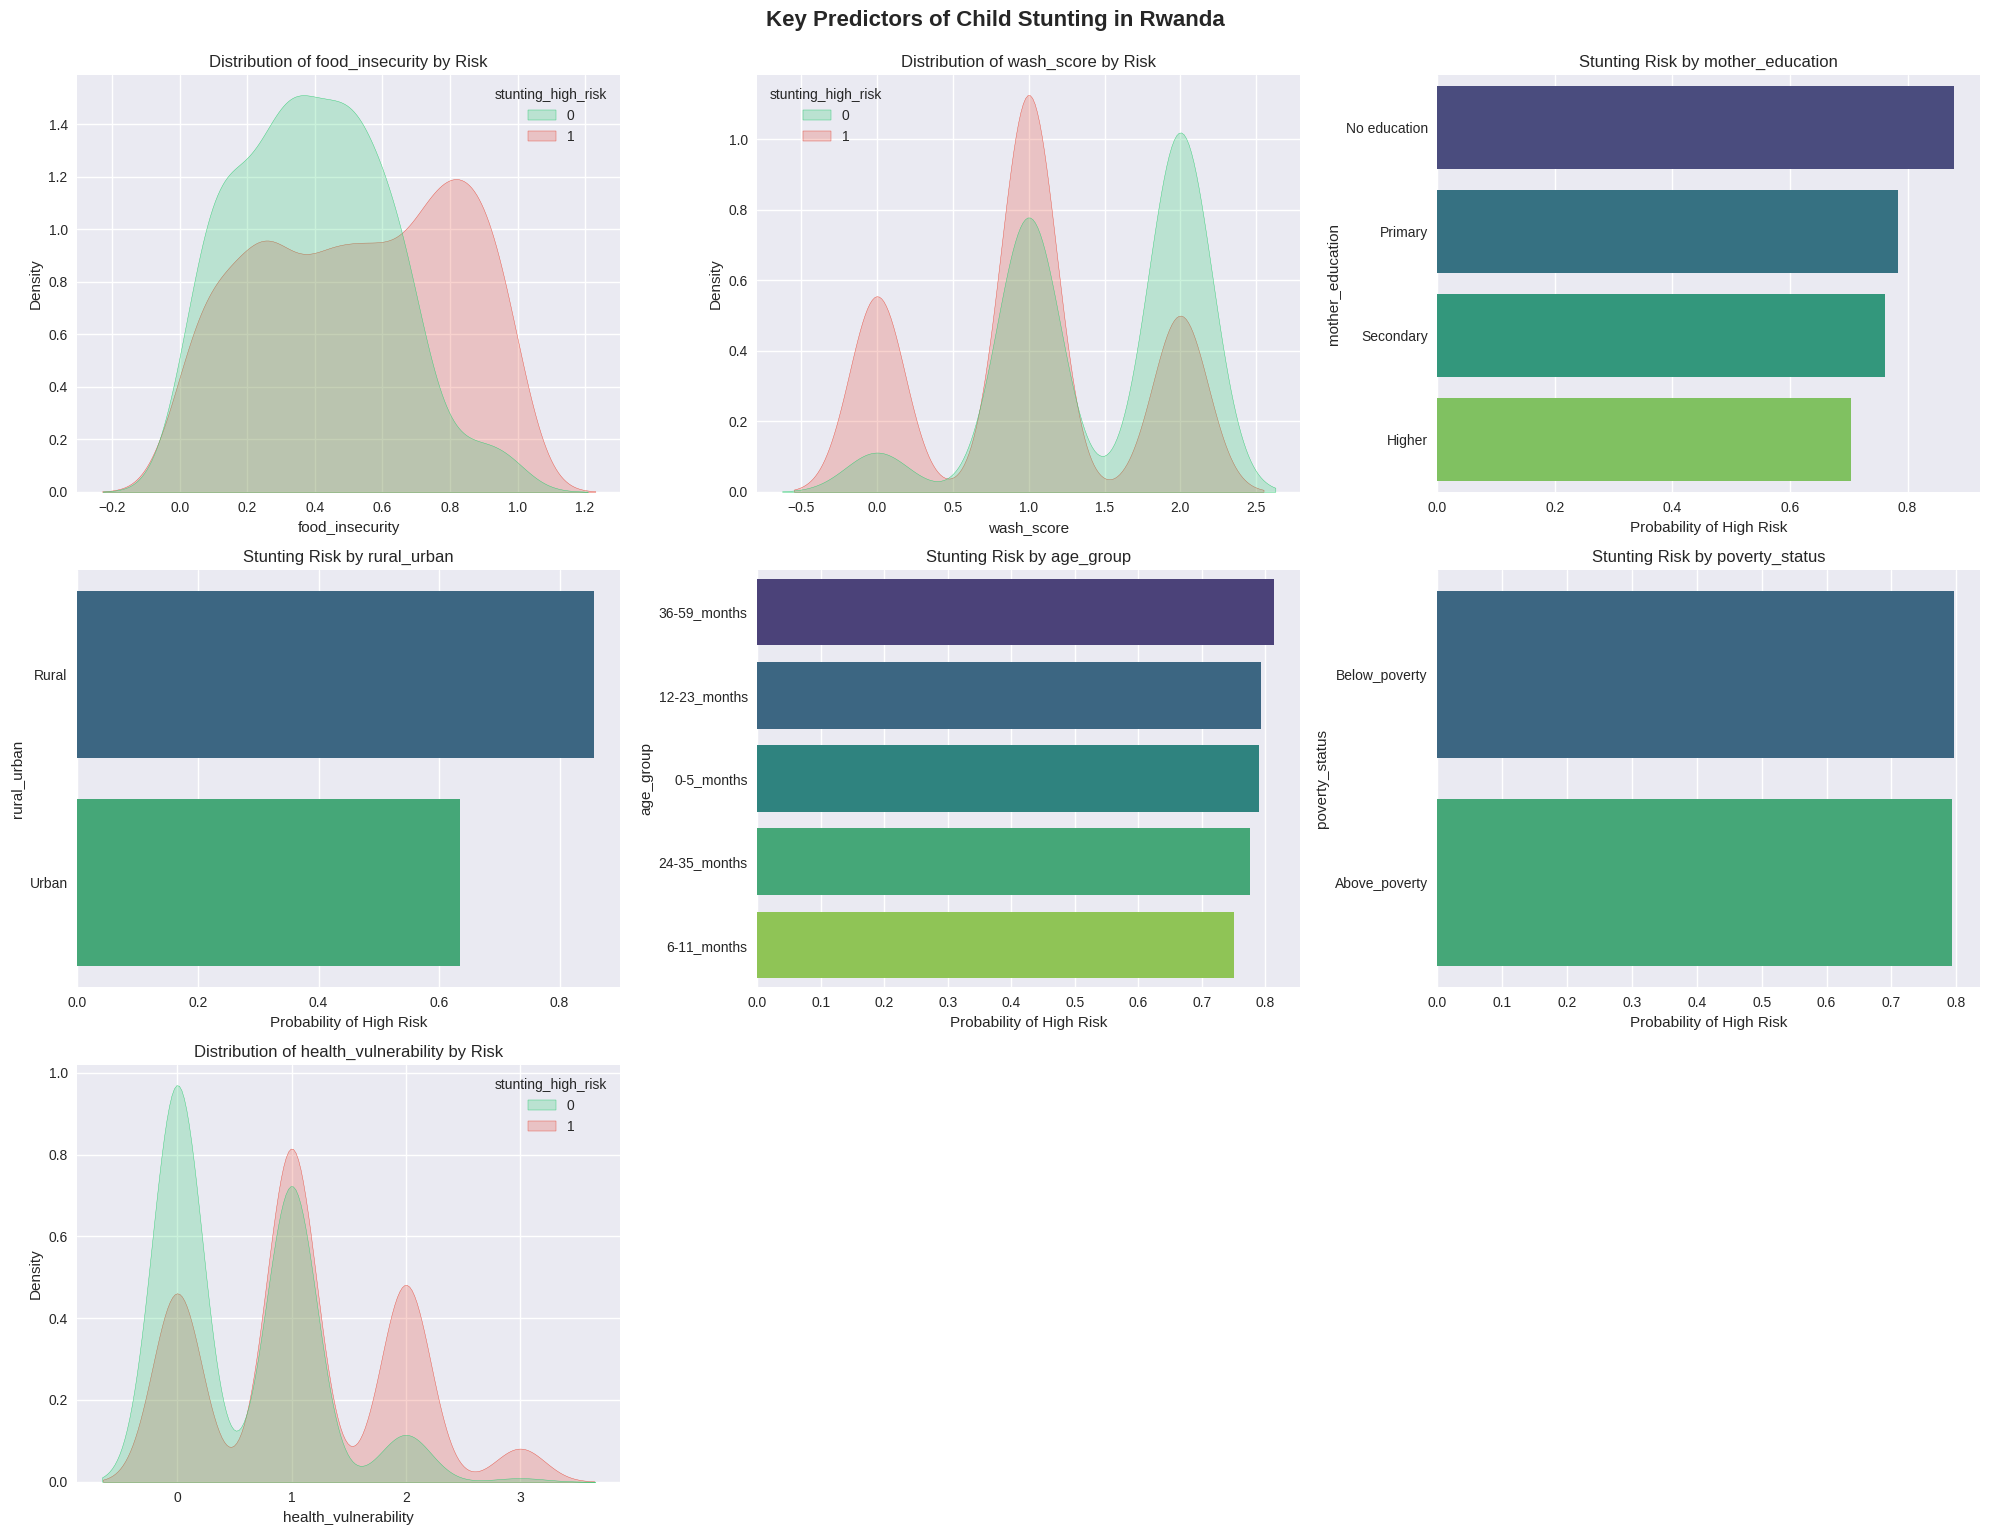

In [22]:
# Set up the visualization framework
print(" DATA VISUALIZATION SECTION")
print("=" * 50)

# 4.1 Target Variable Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
target_counts = df['stunting_high_risk'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.pie(target_counts, labels=['Low Risk', 'High Risk'], autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribution of Stunting Risk (Target Variable)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='stunting_risk_score', hue='stunting_high_risk',
             bins=30, kde=True, palette=colors)
plt.title('Stunting Risk Score Distribution by Risk Category')
plt.xlabel('Stunting Risk Score (%)')
plt.ylabel('Frequency')
plt.axvline(x=35, color='red', linestyle='--', label='Risk Threshold (35%)')
plt.legend()

plt.tight_layout()
plt.show()

# 4.2 Correlation Heatmap - Focus on Strong Correlations
print(" STRONG CORRELATION ANALYSIS")
print("=" * 50)

# Select numerical features for correlation analysis
numerical_features = ['age_months', 'household_income', 'family_size', 'food_insecurity',
                     'clean_water_access', 'improved_sanitation', 'stunting_risk_score',
                     'wash_score', 'health_vulnerability', 'composite_risk_score']

correlation_matrix = df[numerical_features + ['stunting_high_risk']].corr()

# Focus on correlations with target variable
target_correlations = correlation_matrix['stunting_high_risk'].sort_values(ascending=False)
print("Correlations with Stunting High Risk:")
print(target_correlations)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, mask=mask, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap\n(Strong Correlations Highlighted)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4.3 Strong Correlation Pairs Visualization
print(" STRONG CORRELATION PAIRS (|r| > 0.3)")
print("=" * 50)

strong_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.3 and correlation_matrix.columns[i] != correlation_matrix.columns[j]:
            strong_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

# Sort by absolute correlation strength
strong_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("Top Strongly Correlated Feature Pairs:")
for feat1, feat2, corr in strong_corr_pairs[:10]:
    print(f"  {feat1} ↔ {feat2}: {corr:.3f}")

# 4.4 Visualize Top Correlations with Target
top_corr_features = target_correlations[1:6]  # Exclude self-correlation

plt.figure(figsize=(15, 10))
for i, (feature, corr) in enumerate(top_corr_features.items()):
    plt.subplot(2, 3, i+1)

    if df[feature].nunique() > 10:  # Continuous feature
        sns.boxplot(data=df, x='stunting_high_risk', y=feature, palette=colors)
        plt.title(f'{feature}\nCorrelation: {corr:.3f}')
    else:  # Categorical/binary feature
        cross_tab = pd.crosstab(df[feature], df['stunting_high_risk'], normalize='index')
        cross_tab.plot(kind='bar', ax=plt.gca(), color=colors)
        plt.title(f'{feature}\nCorrelation: {corr:.3f}')
        plt.legend(['Low Risk', 'High Risk'])

    plt.xticks([0, 1], ['Low Risk', 'High Risk'])

plt.tight_layout()
plt.show()


# 4.5 Feature Importance by Risk Category - Detailed Analysis
print(" KEY PREDICTORS BY RISK CATEGORY")
print("=" * 50)

# Analyze how key features differ between risk groups
key_features = ['food_insecurity', 'wash_score', 'mother_education', 'rural_urban',
                'age_group', 'poverty_status', 'health_vulnerability']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i+1)

    if df[feature].dtype in ['object', 'category']:
        # Categorical feature
        risk_by_category = df.groupby(feature)['stunting_high_risk'].mean().sort_values(ascending=False)
        sns.barplot(x=risk_by_category.values, y=risk_by_category.index, palette='viridis')
        plt.title(f'Stunting Risk by {feature}')
        plt.xlabel('Probability of High Risk')

    else:
        # Numerical feature
        sns.kdeplot(data=df, x=feature, hue='stunting_high_risk', common_norm=False,
                   palette=colors, fill=True)
        plt.title(f'Distribution of {feature} by Risk')
        plt.xlabel(feature)

    plt.tight_layout()

plt.suptitle('Key Predictors of Child Stunting in Rwanda', fontsize=16, fontweight='bold', y=1.02)
plt.show()

***5. Feature Selection and Preprocessing***

In [23]:
print(" FEATURE SELECTION AND PREPROCESSING")
print("=" * 50)

# Select features based on correlation analysis and domain knowledge
selected_features = [

    # Strong correlates from analysis
    'food_insecurity',
    'wash_score',
    'composite_risk_score',
    'stunting_risk_score',

    # Demographic features
    'age_months',
    'rural_urban',
    'region',

    # Socio-economic features
    'household_income',
    'mother_education',
    'poverty_status',

    # Health practices
    'breastfeeding',
    'vaccination_complete',
    'diarrhea_last_week',
    'health_vulnerability',

    # Family structure
    'family_size'
]

target_variable = 'stunting_high_risk'

print("Selected features for modeling:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

# Create feature and target sets
X = df[selected_features]
y = df[target_variable]

print(f"Feature set shape: {X.shape}")
print(f"Target set shape: {y.shape}")


# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print(" Preprocessing pipeline created!")

 FEATURE SELECTION AND PREPROCESSING
Selected features for modeling:
   1. food_insecurity
   2. wash_score
   3. composite_risk_score
   4. stunting_risk_score
   5. age_months
   6. rural_urban
   7. region
   8. household_income
   9. mother_education
  10. poverty_status
  11. breastfeeding
  12. vaccination_complete
  13. diarrhea_last_week
  14. health_vulnerability
  15. family_size
Feature set shape: (1000, 15)
Target set shape: (1000,)
Categorical features: ['rural_urban', 'region', 'mother_education', 'poverty_status']
Numerical features: ['food_insecurity', 'wash_score', 'composite_risk_score', 'stunting_risk_score', 'age_months', 'household_income', 'breastfeeding', 'vaccination_complete', 'diarrhea_last_week', 'health_vulnerability', 'family_size']
 Preprocessing pipeline created!


***6. Model Training with Random Forest***

In [24]:
print(" MODEL TRAINING - RANDOM FOREST")
print("=" * 50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Positive class in training: {y_train.mean():.2%}")
print(f"Positive class in testing: {y_test.mean():.2%}")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    preprocessor.fit_transform(X_train), y_train
)

print(" Class imbalance handled using SMOTE")
print(f"Resampled training set: {X_train_resampled.shape[0]} samples")
print(f"Positive class after resampling: {y_train_resampled.mean():.2%}")

# Define Random Forest model with hyperparameter grid
print(" PERFORMING HYPERPARAMETER TUNING FOR RANDOM FOREST...")
print("=" * 50)

# Create pipeline with preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__class_weight': ['balanced', None]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Store best model
best_model = grid_search.best_estimator_

print(f" Best Random Forest F1-score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

 MODEL TRAINING - RANDOM FOREST
Training set: 800 samples
Testing set: 200 samples
Positive class in training: 79.38%
Positive class in testing: 79.50%
 Class imbalance handled using SMOTE
Resampled training set: 1270 samples
Positive class after resampling: 50.00%
 PERFORMING HYPERPARAMETER TUNING FOR RANDOM FOREST...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
 Best Random Forest F1-score: 0.9984
Best parameters: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


***7. Model Evaluation***

 MODEL EVALUATION
Random Forest Performance:
  Accuracy:  0.9950
  Precision: 0.9938
  Recall:    1.0000
  F1-Score:  0.9969
  ROC-AUC:   1.0000
 DETAILED ANALYSIS OF RANDOM FOREST MODEL
 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Low Risk       1.00      0.98      0.99        41
   High Risk       0.99      1.00      1.00       159

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



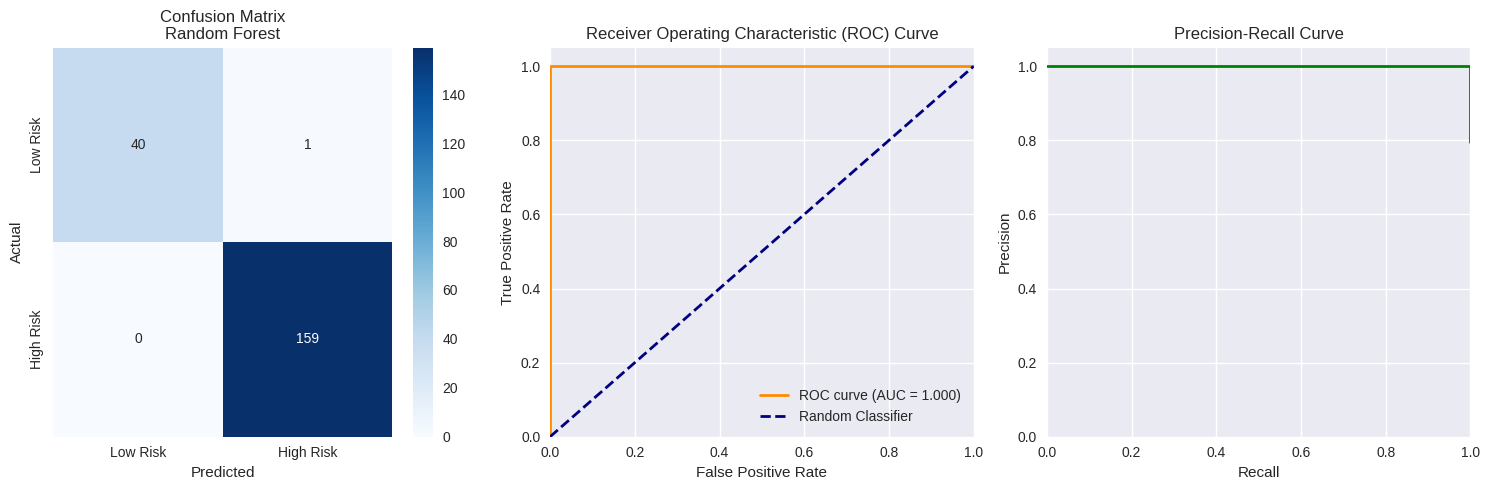

In [25]:
print(" MODEL EVALUATION")
print("=" * 50)


# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print("Random Forest Performance:")
print(f"  Accuracy:  {results['accuracy']:.4f}")
print(f"  Precision: {results['precision']:.4f}")
print(f"  Recall:    {results['recall']:.4f}")
print(f"  F1-Score:  {results['f1']:.4f}")
print(f"  ROC-AUC:   {results['roc_auc']:.4f}")

# Detailed Analysis
print(" DETAILED ANALYSIS OF RANDOM FOREST MODEL")
print("=" * 50)

# Classification report
print(" CLASSIFICATION REPORT")
print("=" * 30)
print(classification_report(y_test, y_pred,
                          target_names=['Low Risk', 'High Risk']))


# Confusion Matrix and Curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix\nRandom Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {results["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.tight_layout()
plt.show()

 ***8. Feature Importance Analysis***

 FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:


,feature,importance
3,stunting_risk_score,0.553985
2,composite_risk_score,0.118671
0,food_insecurity,0.063628
9,health_vulnerability,0.033205
1,wash_score,0.032673
12,rural_urban_Urban,0.028799
6,breastfeeding,0.027624
11,rural_urban_Rural,0.026616
5,household_income,0.025404
4,age_months,0.021751


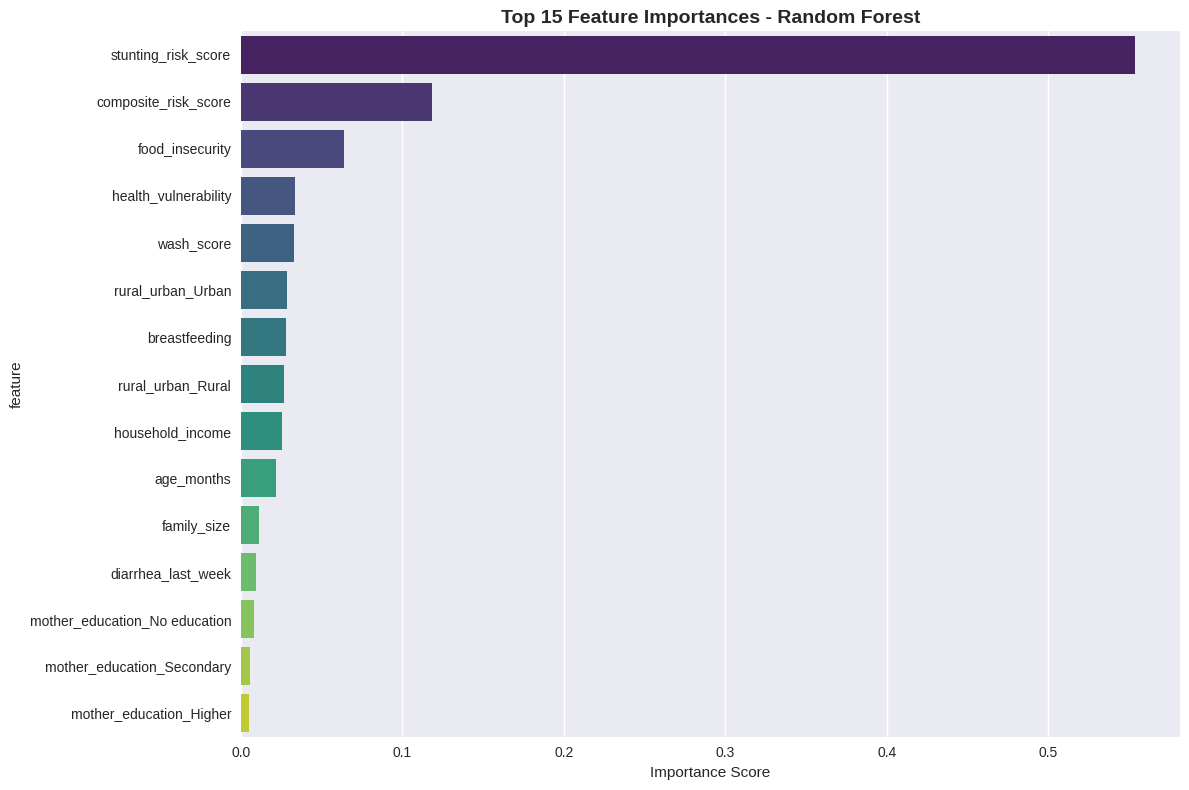

In [26]:
print(" FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)


# Get feature names after preprocessing
feature_names = numerical_features.copy()
for feature in categorical_features:
    # Get one-hot encoded feature names
    unique_values = X[feature].unique()
    for value in unique_values:
        feature_names.append(f"{feature}_{value}")

# Extract feature importance from the model
importances = best_model.named_steps['model'].feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names[:len(importances)],  # Match lengths
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
display(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

***9. Model Deployment Preparation***

In [27]:
print(" MODEL DEPLOYMENT PREPARATION")
print("=" * 50)


model_filename = 'best_malnutrition_model_random_forest.pkl'
joblib.dump(best_model, model_filename)

print(f" Model saved as: {model_filename}")

# Create a prediction function for new data
def predict_stunting_risk(new_data, model=best_model, feature_names=selected_features):
    """
    Predict stunting risk for new child data
    """
    # Ensure the input has the right features
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = new_data.copy()

    # Make sure all required features are present
    missing_features = set(feature_names) - set(new_df.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")

    # Reorder columns to match training data
    new_df = new_df[feature_names]

    # Make prediction
    prediction = model.predict(new_df)[0]
    probability = model.predict_proba(new_df)[0, 1]

    return {
        'stunting_high_risk': bool(prediction),
        'risk_probability': float(probability),
        'risk_category': 'High Risk' if prediction else 'Low Risk',
        'confidence': max(probability, 1-probability)
    }

 MODEL DEPLOYMENT PREPARATION
 Model saved as: best_malnutrition_model_random_forest.pkl


***10. USER INPUT TESTING SCRIPT - IMPROVED VERSION***

In [27]:
print(" USER INPUT TESTING INTERFACE - IMPROVED VERSION")
print("=" * 50)

def validate_user_input(user_data):
    """
    Validate user input and provide warnings for unusual values
    """
    warnings = []

    # Age validation (typical stunting monitoring: 0-59 months)
    if user_data['age_months'] > 59:
        warnings.append(f"  Age {user_data['age_months']} months is outside typical stunting monitoring range (0-59 months)")

    # Income validation
    income_stats = df['household_income'].describe()
    if user_data['household_income'] < income_stats['25%']:
        warnings.append(f"  Household income is in bottom 25% (high poverty risk)")
    elif user_data['household_income'] > income_stats['75%']:
        warnings.append(f"  Household income is in top 25% (low poverty risk)")

    # Food insecurity validation
    if user_data['food_insecurity'] > 0.7:
        warnings.append("  High food insecurity level detected")
    elif user_data['food_insecurity'] < 0.1:
        warnings.append(" Very low food insecurity level")

    # WASH score validation
    if user_data['wash_score'] == 0:
        warnings.append(" Critical: No clean water or sanitation access")
    elif user_data['wash_score'] == 2:
        warnings.append(" Excellent WASH conditions")

    # Stunting risk score validation
    if user_data['stunting_risk_score'] > 50:
        warnings.append(f" High clinical risk score ({user_data['stunting_risk_score']}%)")
    elif user_data['stunting_risk_score'] < 20:
        warnings.append(f" Low clinical risk score ({user_data['stunting_risk_score']}%)")

    return warnings

def calculate_risk_factors(user_data):
    """
    Calculate and weight risk factors more comprehensively
    """
    risk_factors = []
    risk_score = 0

    # Economic factors (weight: 25%)
    income_per_capita = user_data['household_income'] / user_data['family_size']
    if income_per_capita < df['household_income'].quantile(0.3):
        risk_factors.append(f"  - Poverty: income per capita {income_per_capita:,.0f} RWF")
        risk_score += 0.25

    # Food security (weight: 25%)
    if user_data['food_insecurity'] > 0.5:
        risk_factors.append(f"  - Food insecurity: {user_data['food_insecurity']:.0%}")
        risk_score += 0.25
    elif user_data['food_insecurity'] > 0.3:
        risk_factors.append(f"  - Moderate food insecurity: {user_data['food_insecurity']:.0%}")
        risk_score += 0.15

    # WASH conditions (weight: 20%)
    if user_data['wash_score'] == 0:
        risk_factors.append("  - Critical WASH: no clean water or sanitation")
        risk_score += 0.20
    elif user_data['wash_score'] == 1:
        risk_factors.append("  - Poor WASH: limited water/sanitation access")
        risk_score += 0.10

    # Health factors (weight: 20%)
    health_risks = 0
    if user_data['diarrhea_last_week'] == 1:
        health_risks += 1
        risk_factors.append("  - Recent diarrhea infection")
    if user_data['vaccination_complete'] == 0:
        health_risks += 1
        risk_factors.append("  - Incomplete vaccination")
    if user_data['breastfeeding'] == 0 and user_data['age_months'] < 24:
        health_risks += 1
        risk_factors.append("  - No breastfeeding (for child < 2 years)")

    risk_score += (health_risks / 3) * 0.20

    # Clinical assessment (weight: 10%)
    if user_data['stunting_risk_score'] > 35:
        risk_factors.append(f"  - High clinical risk: {user_data['stunting_risk_score']}%")
        risk_score += 0.10

    return risk_factors, risk_score

def get_user_input_improved():
    """
    Get user input for all required features manually with better guidance
    """
    print("Please enter the following information for the child:")
    print("=" * 40)

    user_data = {}

    # Numerical inputs with better guidance
    print("\n NUMERICAL FEATURES:")
    user_data['age_months'] = float(input("Age in months (0-59 typical): "))
    user_data['household_income'] = float(input("Household income (RWF): "))
    user_data['family_size'] = int(input("Family size: "))
    user_data['food_insecurity'] = float(input("Food insecurity (0-1, where 1=high insecurity): "))
    user_data['breastfeeding'] = int(input("Breastfeeding (0=No, 1=Yes): "))
    user_data['vaccination_complete'] = int(input("Vaccination complete (0=No, 1=Yes): "))
    user_data['diarrhea_last_week'] = int(input("Diarrhea last week (0=No, 1=Yes): "))
    user_data['clean_water_access'] = int(input("Clean water access (0=No, 1=Yes): "))
    user_data['improved_sanitation'] = int(input("Improved sanitation (0=No, 1=Yes): "))
    user_data['stunting_risk_score'] = float(input("Stunting risk score (0-100%): "))

    # Calculate derived features
    user_data['wash_score'] = user_data['clean_water_access'] + user_data['improved_sanitation']
    user_data['health_vulnerability'] = (
        user_data['diarrhea_last_week'] +
        (1 - user_data['vaccination_complete']) +
        (1 - user_data['breastfeeding'])
    )
    user_data['composite_risk_score'] = (
        user_data['food_insecurity'] +
        (1 - user_data['clean_water_access']) +
        (1 - user_data['improved_sanitation']) +
        user_data['health_vulnerability'] / 3
    )

    # Categorical inputs
    print("\n CATEGORICAL FEATURES:")
    user_data['rural_urban'] = input("Rural or Urban? ").strip()
    user_data['region'] = input("Region: ").strip()
    user_data['mother_education'] = input("Mother's education (None/Primary/Secondary/Higher): ").strip()

    # Poverty status (calculated based on dataset distribution)
    poverty_threshold = df['household_income'].quantile(0.3)
    user_data['poverty_status'] = 'Below_poverty' if user_data['household_income'] < poverty_threshold else 'Above_poverty'

    return user_data

def interactive_prediction_improved():
    """
    Improved interactive function with better risk assessment
    """
    print(" MALNUTRITION RISK PREDICTION TOOL - IMPROVED")
    print("=" * 50)
    print("This tool predicts the risk of child stunting based on various factors.")
    print("\n")

    while True:
        try:
            # Get user input
            user_data = get_user_input_improved()

            # Validate input and get warnings
            input_warnings = validate_user_input(user_data)

            # Make prediction
            prediction_result = predict_stunting_risk(user_data)

            # Calculate comprehensive risk factors
            risk_factors, manual_risk_score = calculate_risk_factors(user_data)

            # Display results with enhanced analysis
            print("\n" + "=" * 50)
            print(" PREDICTION RESULTS:")
            print("=" * 50)
            print(f"Risk Category: {prediction_result['risk_category']}")
            print(f"Risk Probability: {prediction_result['risk_probability']:.1%}")
            print(f"Confidence: {prediction_result['confidence']:.1%}")

            # Display input warnings
            if input_warnings:
                print("\n INPUT VALIDATION NOTES:")
                for warning in input_warnings:
                    print(warning)

            # Enhanced risk factor analysis
            print("\n COMPREHENSIVE RISK ASSESSMENT:")
            if risk_factors:
                for factor in risk_factors:
                    print(factor)
                print(f"\nOverall Risk Score: {manual_risk_score:.1%} (manual calculation)")
            else:
                print("  - No significant risk factors identified")
                print(f"\nOverall Risk Score: {manual_risk_score:.1%} (manual calculation)")

            # Compare model vs manual assessment
            model_risk = prediction_result['risk_probability']
            discrepancy = abs(model_risk - manual_risk_score)

            if discrepancy > 0.3:  # 30% difference
                print(f"\n  NOTE: Significant difference between model prediction ({model_risk:.1%}) and manual risk assessment ({manual_risk_score:.1%})")
            elif discrepancy > 0.2:  # 20% difference
                print(f"\n  NOTE: Moderate difference between model prediction ({model_risk:.1%}) and manual risk assessment ({manual_risk_score:.1%})")

            print("\n" + "=" * 50)

        except Exception as e:
            print(f" Error: {e}")
            print("Please try again with valid inputs.")

        # Ask if user wants to continue
        continue_pred = input("\nDo you want to make another prediction? (yes/no): ").strip().lower()
        if continue_pred not in ['yes', 'y']:
            print("Thank you for using the Malnutrition Risk Prediction Tool!")
            break

# Run the improved interactive prediction tool
interactive_prediction_improved()